In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Found GPU at: /device:GPU:0
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.4506614129999775
GPU (s):
0.08929438999996364
GPU speedup over CPU: 38x


In [ ]:
!pip i

In [ ]:
import os
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array

### Création des datasets

In [ ]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/Computer\ Vision/brain_tumor .

In [ ]:
base_dir = "brain_tumor"
crop_size = 300
upscale_factor = 3
batch_size=32
input_size = crop_size // upscale_factor

train_ds = image_dataset_from_directory(
   os.path.join(base_dir, "Training"),
   batch_size=batch_size,
   image_size=(crop_size, crop_size),
   validation_split=0.2,
   subset="training",
   seed=1337,
   label_mode=None
)

valid_ds = image_dataset_from_directory(
    os.path.join(base_dir, "Training"),
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None
)

Found 2842 files belonging to 1 classes.
Using 2274 files for training.
Found 2842 files belonging to 1 classes.
Using 568 files for validation.


In [ ]:
test_path = os.path.join(base_dir, "Testing")

test_img_paths = sorted(
    [
        os.path.join(test_path, folder, fname)
        for folder in os.listdir(test_path)
        for fname in os.listdir(os.path.join(test_path, folder))
        if fname.endswith('.jpg')
    ]
)


**Normalisation des pixels**

In [ ]:
def normaliser(input):
  return input/255.0

train_ds = train_ds.map(normaliser)
valid_ds = valid_ds.map(normaliser)

**Prétraitement sur les images**

- Conversion espace RGB vers YUV
- Recadrage, récupération du canal Y (luminance) and redimensionner les images low resolution. On considère la luminance car les humains sont le plus sensible à cela
- Pour les images super résolues, on recadre et récupère le canal y

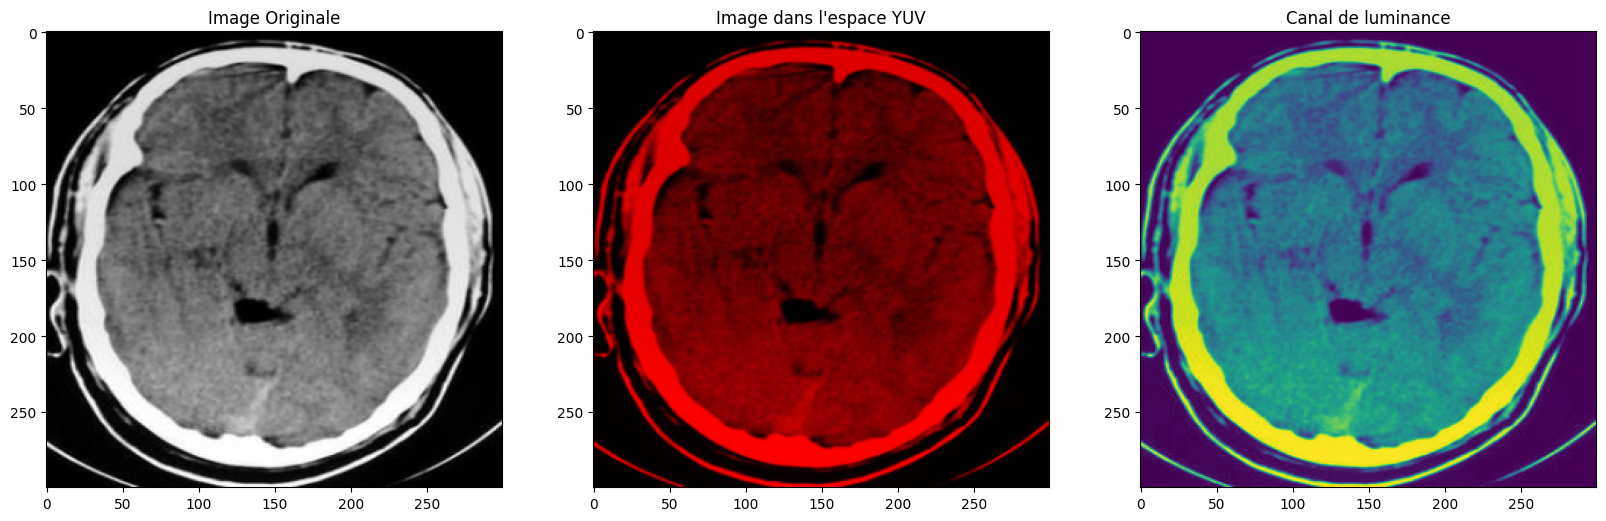

In [ ]:
# Afficher les étapes de prétraitement effectuer
image_dataset = train_ds.take(1)
image = next(iter(image_dataset))[0]
input_image = tf.image.rgb_to_yuv(image)
y, u, v = tf.split(input_image, 3, axis=len(input_image.shape)-1)
fig, axes = plt.subplots(1, 3, figsize=(20, 16))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Image Originale")
axes[1].imshow(input_image)
axes[1].set_title("Image dans l'espace YUV")
axes[2].imshow(y)
axes[2].set_title("Canal de luminance")
plt.show()

In [ ]:
def pretraitement_input(input, input_size=input_size, upscale_factor=upscale_factor):
  input = tf.image.rgb_to_yuv(input)
  y, u, v = tf.split(input, 3, axis=len(input.shape)-1)
  return tf.image.resize(y, [input_size, input_size], method="area")

def pretraitement_output(input):
   input = tf.image.rgb_to_yuv(input)
   y, u, v = tf.split(input, 3, axis=len(input.shape)-1)
   return y

train_ds = train_ds.map(
    lambda x: (pretraitement_input(x), pretraitement_output(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (pretraitement_input(x), pretraitement_output(x))
)
valid_ds = valid_ds

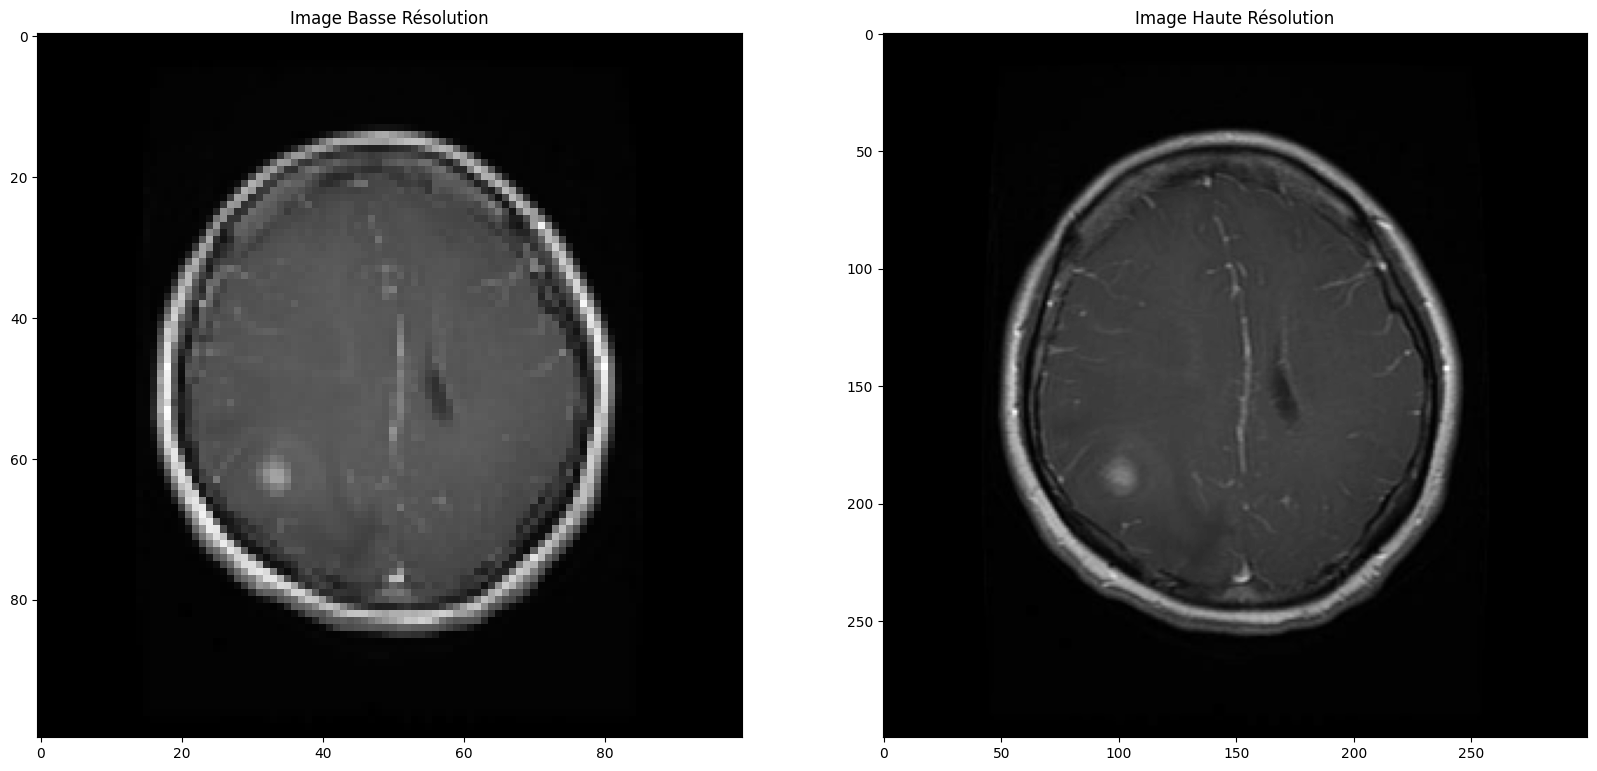

In [ ]:
# Afficher l'image basse résolution et l'image haute résolution
fig, axes = plt.subplots(1, 2, figsize=(20, 16))

for batch in train_ds.take(1):
  img1 = batch[0][0]
  img2 = batch[1][0]
  axes[0].imshow(img1, cmap="gray")
  axes[0].set_title("Image Basse Résolution")
  axes[1].imshow(img2, cmap="gray")
  axes[1].set_title("Image Haute Résolution")
  break

plt.show()

**Définir l'architecture du modèle CNN**

In [ ]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

**Utils**

1. plot_result pour visualiser nos résultat
2. get_lowres_image pour convertir une image en sa version basse résolution
3. upscale_image pour transformer une image basse résolution en sa version haute résolution reconstruite par le modèle. Dans cette fonction on utilise le canal y de l'espace YUV comme entrée et on combine la sortie avec les autres canaux pour obtenir une image RGB.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

def get_lowres_image(img, upscale_factor):
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input, verbose=0)

    out_img_y = out[0]
    out_img_y *= 255.0

    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [ ]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_48 (Conv2D)          (None, None, None, 64)    1664      
                                                                 
 conv2d_49 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 conv2d_50 (Conv2D)          (None, None, None, 32)    18464     
                                                                 
 conv2d_51 (Conv2D)          (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space_1 (TFO  (None, None, None, 1)    0         
 pLambda)                                                        
                                                           

In [ ]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/100
Mean PSNR for epoch: 28.05
72/72 - 12s - loss: 0.0073 - val_loss: 0.0016 - 12s/epoch - 162ms/step
Epoch 2/100
Mean PSNR for epoch: 29.93
72/72 - 9s - loss: 0.0012 - val_loss: 0.0010 - 9s/epoch - 126ms/step
Epoch 3/100
Mean PSNR for epoch: 31.08
72/72 - 9s - loss: 8.4976e-04 - val_loss: 7.8344e-04 - 9s/epoch - 128ms/step
Epoch 4/100
Mean PSNR for epoch: 31.01
72/72 - 11s - loss: 7.7639e-04 - val_loss: 8.1258e-04 - 11s/epoch - 156ms/step
Epoch 5/100
Mean PSNR for epoch: 31.51
72/72 - 11s - loss: 7.3243e-04 - val_loss: 7.0896e-04 - 11s/epoch - 151ms/step
Epoch 6/100
Mean PSNR for epoch: 31.23
72/72 - 11s - loss: 7.3823e-04 - val_loss: 7.4867e-04 - 11s/epoch - 159ms/step
Epoch 7/100
Mean PSNR for epoch: 31.86
72/72 - 10s - loss: 7.0073e-04 - val_loss: 6.7279e-04 - 10s/epoch - 136ms/step
Epoch 8/100
Mean PSNR for epoch: 32.03
72/72 - 10s - loss: 6.6304e-04 - val_loss: 6.5402e-04 - 10s/epoch - 140ms/step
Epoch 9/100
Mean PSNR for epoch: 31.81
72/72 - 12s - loss: 6.4515e-04 - val_

On exécute les prédictions du modèle et on visualise les résultats

In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
results = []

for index, test_img_path in enumerate(test_img_paths[35:45]):
    j = 0
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)
    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr
    results.append([lowres_img, highres_img, prediction])

Avg. PSNR of lowres images is 30.7003
Avg. PSNR of reconstructions is 33.7627


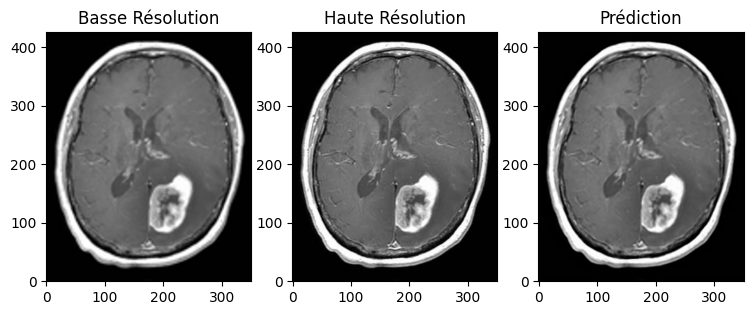

In [ ]:
print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))
i = 0

fig, axes = plt.subplots(1, 3, figsize=(9, 18))

for image in results[0]:
    img_array = img_to_array(image)
    img_array = img_array.astype("float32") / 255.0
    im = axes[i].imshow(img_array[::-1], origin="lower")
    if i == 0:
      axes[i].set_title("Basse Résolution")
    elif i == 1:
      axes[i].set_title("Haute Résolution")
    else:
      axes[i].set_title("Prédiction")
    i += 1

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Computer Vision/sr_model.h5")